# Assignment 4

### 1. 复习上课内容以及复现课程代码

在本部分，你需要复习上课内容和课程代码后，自己复现课程代码。

### 课程代码复现
- 前向后向神经网络深度学习

In [7]:
"""
Check out the new network architecture and dataset!
Notice that the weights and biases are
generated randomly.
No need to change anything, but feel free to tweak
to test your network, play around with the epochs, batch size, etc!
"""
from sklearn.datasets import load_boston
from sklearn.utils import shuffle, resample
data = load_boston()
X_ = data['data']
y_ = data['target']
losses = []

In [8]:
# Normalize data
import numpy as np
X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis=0)

n_features = X_.shape[1]
n_hidden = 10
W1_ = np.random.randn(n_features, n_hidden)
b1_ = np.zeros(n_hidden)
W2_ = np.random.randn(n_hidden, 1)
b2_ = np.zeros(1)

In [9]:
# class definition
class Node:
    def __init__(self, inputs=[]):
        self.inputs = inputs
        self.outputs = []

        for n in self.inputs:
            n.outputs.append(self)
            # set 'self' node as inbound_nodes's outbound_nodes

        self.value = None

        self.gradients = {}
        # keys are the inputs to this node, and their
        # values are the partials of this node with 
        # respect to that input.
        # \partial{node}{input_i}
        

    def forward(self):
        '''
        Forward propagation. 
        Compute the output value vased on 'inbound_nodes' and store the 
        result in self.value
        '''

        raise NotImplemented
    

    def backward(self):

        raise NotImplemented


In [10]:
class Input(Node):
    def __init__(self):
        '''
        An Input node has no inbound nodes.
        So no need to pass anything to the Node instantiator.
        '''
        Node.__init__(self)

    def forward(self, value=None):
        '''
        Only input node is the node where the value may be passed
        as an argument to forward().
        All other node implementations should get the value of the 
        previous node from self.inbound_nodes
        
        Example: 
        val0: self.inbound_nodes[0].value
        '''
        if value is not None:
            self.value = value
            ## It's is input node, when need to forward, this node initiate self's value.

        # Input subclass just holds a value, such as a data feature or a model parameter(weight/bias)
        
    def backward(self):
        self.gradients = {self:0} # initialization 
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self] = grad_cost * 1
            
        
        # input N --> N1, N2
        # \partial L / \partial N 
        # ==> \partial L / \partial N1 * \ partial N1 / \partial N

In [11]:
class Add(Node):
    def __init__(self, *nodes):
        Node.__init__(self, nodes)


    def forward(self):
        self.value = sum(map(lambda n: n.value, self.inputs))
        ## when execute forward, this node caculate value as defined.


In [12]:
class Linear(Node):
    def __init__(self, nodes, weights, bias):
        Node.__init__(self, [nodes, weights, bias])

    def forward(self):
        inputs = self.inputs[0].value
        weights = self.inputs[1].value
        bias = self.inputs[2].value

        self.value = np.dot(inputs, weights) + bias
        
    def backward(self):

        # initial a partial for each of the inbound_nodes.
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}

        for n in self.outputs:
            # Get the partial of the cost w.r.t this node.
            grad_cost = n.gradients[self]

            self.gradients[self.inputs[0]] = np.dot(grad_cost, self.inputs[1].value.T)
            self.gradients[self.inputs[1]] = np.dot(self.inputs[0].value.T, grad_cost)
            self.gradients[self.inputs[2]] = np.sum(grad_cost, axis=0, keepdims=False)

        # WX + B / W ==> X
        # WX + B / X ==> W

In [13]:
class MSE(Node):
    def __init__(self, y, a):
        Node.__init__(self, [y, a])


    def forward(self):
        y = self.inputs[0].value.reshape(-1, 1)
        a = self.inputs[1].value.reshape(-1, 1)
        assert(y.shape == a.shape)

        self.m = self.inputs[0].value.shape[0]
        self.diff = y - a

        self.value = np.mean(self.diff**2)


    def backward(self):
        self.gradients[self.inputs[0]] = (2 / self.m) * self.diff
        self.gradients[self.inputs[1]] = (-2 / self.m) * self.diff

In [14]:
class Sigmoid(Node):
    def __init__(self, node):
        Node.__init__(self, [node])


    def _sigmoid(self, x):
        return 1./(1 + np.exp(-1 * x))

    def forward(self):
        self.x = self.inputs[0].value   # [0] input is a list
        self.value = self._sigmoid(self.x)

    def backward(self):
        self.partial = self._sigmoid(self.x) * (1 - self._sigmoid(self.x))
        
        # y = 1 / (1 + e^-x)
        # y' = 1 / (1 + e^-x) (1 - 1 / (1 + e^-x))
        
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}

        for n in self.outputs:
            grad_cost = n.gradients[self]  # Get the partial of the cost with respect to this node.

            self.gradients[self.inputs[0]] = grad_cost * self.partial
            # use * to keep all the dimension same!.


In [15]:

def forward_and_backward(outputnode, graph):
    # execute all the forward method of sorted_nodes.

    ## In practice, it's common to feed in mutiple data example in each forward pass rather than just 1. Because the examples can be processed in parallel. The number of examples is called batch size.
    for n in graph:
        n.forward()
        ## each node execute forward, get self.value based on the topological sort result.

    for n in  graph[::-1]:
        n.backward()

    #return outputnode.value

###   v -->  a -->  C
##    b --> C
##    b --> v -- a --> C
##    v --> v ---> a -- > C

In [16]:
def topological_sort(feed_dict):
    """
    Sort generic nodes in topological order using Kahn's Algorithm.
    `feed_dict`: A dictionary where the key is a `Input` node and the value is the respective value feed to that node.
    Returns a list of sorted nodes.
    """

    input_nodes = [n for n in feed_dict.keys()]

    G = {}
    nodes = [n for n in input_nodes]
    while len(nodes) > 0:
        n = nodes.pop(0)
        if n not in G:
            G[n] = {'in': set(), 'out': set()}
        for m in n.outputs:
            if m not in G:
                G[m] = {'in': set(), 'out': set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)

    L = []
    S = set(input_nodes)
    while len(S) > 0:
        n = S.pop()

        if isinstance(n, Input):
            n.value = feed_dict[n]
            ## if n is Input Node, set n'value as 
            ## feed_dict[n]
            ## else, n's value is caculate as its
            ## inbounds

        L.append(n)
        for m in n.outputs:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            # if no other incoming edges add to S
            if len(G[m]['in']) == 0:
                S.add(m)
    return L


In [17]:
def sgd_update(trainables, learning_rate=1e-2):
    # there are so many other update / optimization methods
    # such as Adam, Mom, 
    for t in trainables:
        t.value += -1 * learning_rate * t.gradients[t]

In [18]:
# Neural network
X, y = Input(), Input()
W1, b1 = Input(), Input()
W2, b2 = Input(), Input()

l1 = Linear(X, W1, b1)
s1 = Sigmoid(l1)
l2 = Linear(s1, W2, b2)
cost = MSE(y, l2)

feed_dict = {
    X: X_,
    y: y_,
    W1: W1_,
    b1: b1_,
    W2: W2_,
    b2: b2_
}

epochs = 5000
# Total number of examples
m = X_.shape[0]
batch_size = 16
steps_per_epoch = m // batch_size

graph = topological_sort(feed_dict)
trainables = [W1, b1, W2, b2]

print("Total number of examples = {}".format(m))


Total number of examples = 506


In [19]:
# Step 4
for i in range(epochs):
    loss = 0
    for j in range(steps_per_epoch):
        # Step 1
        # Randomly sample a batch of examples
        X_batch, y_batch = resample(X_, y_, n_samples=batch_size)

        # Reset value of X and y Inputs
        X.value = X_batch
        y.value = y_batch

        # Step 2
        _ = None
        forward_and_backward(_, graph) # set output node not important.

        # Step 3
        rate = 1e-2
    
        sgd_update(trainables, rate)

        loss += graph[-1].value
    
    if i % 100 == 0: 
        print("Epoch: {}, Loss: {:.3f}".format(i+1, loss/steps_per_epoch))
        losses.append(loss)

Epoch: 1, Loss: 167.316
Epoch: 101, Loss: 7.856
Epoch: 201, Loss: 4.705
Epoch: 301, Loss: 4.288
Epoch: 401, Loss: 4.622
Epoch: 501, Loss: 3.862
Epoch: 601, Loss: 4.191
Epoch: 701, Loss: 3.823
Epoch: 801, Loss: 3.480
Epoch: 901, Loss: 4.028
Epoch: 1001, Loss: 3.606
Epoch: 1101, Loss: 3.477
Epoch: 1201, Loss: 3.068
Epoch: 1301, Loss: 3.157
Epoch: 1401, Loss: 3.487
Epoch: 1501, Loss: 3.653
Epoch: 1601, Loss: 3.013
Epoch: 1701, Loss: 3.256
Epoch: 1801, Loss: 3.822
Epoch: 1901, Loss: 2.743
Epoch: 2001, Loss: 3.351
Epoch: 2101, Loss: 3.125
Epoch: 2201, Loss: 2.855
Epoch: 2301, Loss: 3.103
Epoch: 2401, Loss: 3.116
Epoch: 2501, Loss: 3.195
Epoch: 2601, Loss: 3.474
Epoch: 2701, Loss: 2.904
Epoch: 2801, Loss: 3.292
Epoch: 2901, Loss: 2.748
Epoch: 3001, Loss: 3.173
Epoch: 3101, Loss: 3.568
Epoch: 3201, Loss: 3.042
Epoch: 3301, Loss: 2.740
Epoch: 3401, Loss: 3.163
Epoch: 3501, Loss: 2.735
Epoch: 3601, Loss: 2.462
Epoch: 3701, Loss: 2.810
Epoch: 3801, Loss: 2.499
Epoch: 3901, Loss: 3.287
Epoch: 400

In [20]:
def forward(outputNode,graph):
    for n in graph:
        n.forward()
    return outputNode.value

In [21]:
forward(l2,graph)

array([[22.1611133 ],
       [16.03497528],
       [18.90206633],
       [21.69749677],
       [19.00263486],
       [14.59744693],
       [24.26487229],
       [24.26487229],
       [19.94728885],
       [16.27566602],
       [16.82837549],
       [10.98269915],
       [46.5325388 ],
       [47.17698836],
       [11.26536297],
       [18.27336168]])

In [22]:
import matplotlib.pyplot as plt
plt.plot(range(len(losses)), losses)
plt.show()

<Figure size 640x480 with 1 Axes>

In [23]:
import keras
from keras.layers import Dense
from keras.models import Sequential

model = Sequential()

model.add(Dense(units=64, activation='sigmoid', input_dim=13))
model.add(Dense(units=30, activation='sigmoid', input_dim=64))
model.add(Dense(units=1))

model.compile(loss='mse',
              optimizer='sgd',
              metrics=['mse'])

Using TensorFlow backend.


In [ ]:
model.fit(X_, y_, epochs=5000, batch_size=32)

Epoch 1/5000
506/506 [==============================] - 3s 6ms/step - loss: 159.8645 - mean_squared_error: 159.8645
Epoch 2/5000
506/506 [==============================] - 0s 110us/step - loss: 67.6196 - mean_squared_error: 67.6196
Epoch 3/5000
506/506 [==============================] - 0s 130us/step - loss: 51.3605 - mean_squared_error: 51.3605
Epoch 4/5000
506/506 [==============================] - 0s 129us/step - loss: 40.2001 - mean_squared_error: 40.2001
Epoch 5/5000
506/506 [==============================] - 0s 134us/step - loss: 32.2447 - mean_squared_error: 32.2447
Epoch 6/5000
506/506 [==============================] - 0s 132us/step - loss: 27.5698 - mean_squared_error: 27.5698
Epoch 7/5000
506/506 [==============================] - 0s 142us/step - loss: 26.1618 - mean_squared_error: 26.1618
Epoch 8/5000
506/506 [==============================] - 0s 175us/step - loss: 23.8362 - mean_squared_error: 23.8362
Epoch 9/5000
506/506 [==============================] - 0s 166us/step - 

506/506 [==============================] - 0s 99us/step - loss: 9.7945 - mean_squared_error: 9.7945
Epoch 72/5000
506/506 [==============================] - 0s 99us/step - loss: 9.7737 - mean_squared_error: 9.7737
Epoch 73/5000
506/506 [==============================] - 0s 89us/step - loss: 10.2635 - mean_squared_error: 10.2635
Epoch 74/5000
506/506 [==============================] - 0s 99us/step - loss: 9.9962 - mean_squared_error: 9.9962
Epoch 75/5000
506/506 [==============================] - 0s 110us/step - loss: 9.8292 - mean_squared_error: 9.8292
Epoch 76/5000
506/506 [==============================] - 0s 162us/step - loss: 9.6717 - mean_squared_error: 9.6717
Epoch 77/5000
506/506 [==============================] - 0s 152us/step - loss: 9.9199 - mean_squared_error: 9.9199
Epoch 78/5000
506/506 [==============================] - 0s 146us/step - loss: 9.5705 - mean_squared_error: 9.5705
Epoch 79/5000
506/506 [==============================] - 0s 198us/step - loss: 9.7992 - mean_squ

506/506 [==============================] - 0s 158us/step - loss: 5.3433 - mean_squared_error: 5.3433
Epoch 212/5000
506/506 [==============================] - ETA: 0s - loss: 5.5846 - mean_squared_error: 5.58 - 0s 192us/step - loss: 5.3654 - mean_squared_error: 5.3654
Epoch 213/5000
506/506 [==============================] - 0s 146us/step - loss: 5.1741 - mean_squared_error: 5.1741
Epoch 214/5000
506/506 [==============================] - 0s 115us/step - loss: 5.1091 - mean_squared_error: 5.1091
Epoch 215/5000
506/506 [==============================] - 0s 132us/step - loss: 5.2326 - mean_squared_error: 5.2326
Epoch 216/5000
506/506 [==============================] - 0s 148us/step - loss: 5.2085 - mean_squared_error: 5.2085
Epoch 217/5000
506/506 [==============================] - 0s 120us/step - loss: 5.0256 - mean_squared_error: 5.0256
Epoch 218/5000
506/506 [==============================] - 0s 99us/step - loss: 4.8789 - mean_squared_error: 4.8789
Epoch 219/5000
506/506 [============

506/506 [==============================] - 0s 97us/step - loss: 3.6656 - mean_squared_error: 3.6656
Epoch 353/5000
506/506 [==============================] - 0s 101us/step - loss: 3.5847 - mean_squared_error: 3.5847
Epoch 354/5000
506/506 [==============================] - 0s 101us/step - loss: 3.5873 - mean_squared_error: 3.5873
Epoch 355/5000
506/506 [==============================] - 0s 97us/step - loss: 3.4939 - mean_squared_error: 3.4939
Epoch 356/5000
506/506 [==============================] - 0s 102us/step - loss: 3.5489 - mean_squared_error: 3.5489
Epoch 357/5000
506/506 [==============================] - 0s 102us/step - loss: 3.5398 - mean_squared_error: 3.5398
Epoch 358/5000
506/506 [==============================] - 0s 99us/step - loss: 3.6437 - mean_squared_error: 3.6437
Epoch 359/5000
506/506 [==============================] - 0s 106us/step - loss: 3.5445 - mean_squared_error: 3.5445
Epoch 360/5000
506/506 [==============================] - 0s 95us/step - loss: 3.7718 - me

Epoch 423/5000
506/506 [==============================] - 0s 95us/step - loss: 3.1413 - mean_squared_error: 3.1413
Epoch 424/5000
506/506 [==============================] - 0s 95us/step - loss: 2.9519 - mean_squared_error: 2.9519
Epoch 425/5000
506/506 [==============================] - 0s 85us/step - loss: 3.1217 - mean_squared_error: 3.1217
Epoch 426/5000
506/506 [==============================] - 0s 99us/step - loss: 3.0707 - mean_squared_error: 3.0707
Epoch 427/5000
506/506 [==============================] - 0s 102us/step - loss: 2.9731 - mean_squared_error: 2.9731
Epoch 428/5000
506/506 [==============================] - 0s 132us/step - loss: 3.2507 - mean_squared_error: 3.2507
Epoch 429/5000
506/506 [==============================] - 0s 108us/step - loss: 3.1630 - mean_squared_error: 3.1630
Epoch 430/5000
506/506 [==============================] - 0s 101us/step - loss: 3.0063 - mean_squared_error: 3.0063
Epoch 431/5000
506/506 [==============================] - 0s 95us/step - los

506/506 [==============================] - 0s 128us/step - loss: 2.4462 - mean_squared_error: 2.4462
Epoch 564/5000
506/506 [==============================] - 0s 104us/step - loss: 2.3606 - mean_squared_error: 2.3606
Epoch 565/5000
506/506 [==============================] - 0s 114us/step - loss: 2.4082 - mean_squared_error: 2.4082
Epoch 566/5000
506/506 [==============================] - 0s 134us/step - loss: 2.5076 - mean_squared_error: 2.5076
Epoch 567/5000
506/506 [==============================] - 0s 104us/step - loss: 2.3700 - mean_squared_error: 2.3700
Epoch 568/5000
506/506 [==============================] - 0s 95us/step - loss: 2.4080 - mean_squared_error: 2.4080
Epoch 569/5000
506/506 [==============================] - 0s 99us/step - loss: 2.3511 - mean_squared_error: 2.3511
Epoch 570/5000
506/506 [==============================] - 0s 118us/step - loss: 2.3716 - mean_squared_error: 2.3716
Epoch 571/5000
506/506 [==============================] - 0s 120us/step - loss: 2.3742 - 

506/506 [==============================] - 0s 104us/step - loss: 2.0759 - mean_squared_error: 2.0759
Epoch 634/5000
506/506 [==============================] - 0s 107us/step - loss: 2.1992 - mean_squared_error: 2.1992
Epoch 635/5000
506/506 [==============================] - 0s 97us/step - loss: 2.3063 - mean_squared_error: 2.3063
Epoch 636/5000
506/506 [==============================] - 0s 108us/step - loss: 2.2712 - mean_squared_error: 2.2712
Epoch 637/5000
506/506 [==============================] - 0s 102us/step - loss: 2.1127 - mean_squared_error: 2.1127
Epoch 638/5000
506/506 [==============================] - 0s 126us/step - loss: 2.0987 - mean_squared_error: 2.0987
Epoch 639/5000
506/506 [==============================] - 0s 122us/step - loss: 2.1473 - mean_squared_error: 2.1473
Epoch 640/5000
506/506 [==============================] - 0s 122us/step - loss: 2.1416 - mean_squared_error: 2.1416
Epoch 641/5000
506/506 [==============================] - 0s 104us/step - loss: 2.1361 -

506/506 [==============================] - 0s 97us/step - loss: 1.8546 - mean_squared_error: 1.8546
Epoch 774/5000
506/506 [==============================] - 0s 101us/step - loss: 1.8529 - mean_squared_error: 1.8529
Epoch 775/5000
506/506 [==============================] - 0s 126us/step - loss: 1.8946 - mean_squared_error: 1.8946
Epoch 776/5000
506/506 [==============================] - 0s 97us/step - loss: 1.8096 - mean_squared_error: 1.8096
Epoch 777/5000
506/506 [==============================] - 0s 104us/step - loss: 1.8529 - mean_squared_error: 1.8529
Epoch 778/5000
506/506 [==============================] - 0s 97us/step - loss: 1.8318 - mean_squared_error: 1.8318
Epoch 779/5000
506/506 [==============================] - 0s 102us/step - loss: 1.8743 - mean_squared_error: 1.8743
Epoch 780/5000
506/506 [==============================] - 0s 97us/step - loss: 1.8446 - mean_squared_error: 1.8446
Epoch 781/5000
506/506 [==============================] - 0s 95us/step - loss: 1.8707 - mea

506/506 [==============================] - 0s 102us/step - loss: 1.6820 - mean_squared_error: 1.6820
Epoch 914/5000
506/506 [==============================] - 0s 99us/step - loss: 1.6497 - mean_squared_error: 1.6497
Epoch 915/5000
506/506 [==============================] - 0s 120us/step - loss: 1.6529 - mean_squared_error: 1.6529
Epoch 916/5000
506/506 [==============================] - 0s 102us/step - loss: 1.6749 - mean_squared_error: 1.6749
Epoch 917/5000
506/506 [==============================] - ETA: 0s - loss: 1.3106 - mean_squared_error: 1.31 - 0s 106us/step - loss: 1.6388 - mean_squared_error: 1.6388
Epoch 918/5000
506/506 [==============================] - 0s 106us/step - loss: 1.7046 - mean_squared_error: 1.7046
Epoch 919/5000
506/506 [==============================] - 0s 101us/step - loss: 1.6776 - mean_squared_error: 1.6776
Epoch 920/5000
506/506 [==============================] - 0s 106us/step - loss: 1.6983 - mean_squared_error: 1.6983
Epoch 921/5000
506/506 [============

### 2. 回答一下理论题目

#### 1. What does a neuron compute?

In [ ]:
A neuron computes a linear function followed by an activation function.

####  2. Why we use non-linear activation funcitons in neural networks?

In [ ]:
Because linear functions can not express enough.

#### 3. What is the 'Logistic Loss' ?

In [ ]:
Same as cross entropy loss.

#### 4. Assume that you are building a binary classifier for detecting if an image containing cats, which activation functions would you recommen using for the output layer ?

A. ReLU    
B. Leaky ReLU    
C. sigmoid    
D. tanh  

In [ ]:
C

#### 5. Why we don't use zero initialization for all parameters ?

In [ ]:
There would be no loss convergence.

#### 6. Can you implement the softmax function using python ? 

In [ ]:
def softmax(x,axis):# 列向量axis=0，否则1
    exp_x = np.exp(x)
    sum_x = np.sum(exp_x,axis,keepdims = True)
    return exp_x/sum_x

### 3.实践题

#### In this practical part, you will build a simple digits recognizer to check if the digit in the image is larger than 5. This assignmnet will guide you step by step to finish your first small project in this course .

#### 1 - Packages  
sklearn is a famous package for machine learning.   
matplotlib is a common package for vasualization.

In [1]:
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#### 2 - Overvie of the dataset  
    - a training set has m_train images labeled as 0 if the digit < 5 or 1 if the digit >= 5
    - a test set contains m_test images labels as if the digit < 5 or 1 if the digit >= 5
    - eah image if of shape (num_px, num_px ). Thus, each image is square(height=num_px and  width = num_px)

In [2]:
# Loading the data 
digits = datasets.load_digits()

In [14]:
digits.data.shape

(1797, 64)

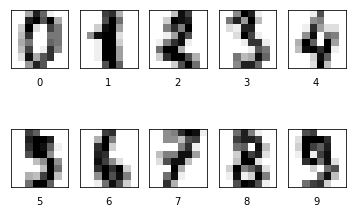

In [3]:
# Vilizating the data
for i in range(1,11):
    plt.subplot(2,5,i)
    plt.imshow(digits.data[i-1].reshape([8,8]),cmap=plt.cm.gray_r)
    plt.text(3,10,str(digits.target[i-1]))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [4]:
# Split the data into training set and test set 
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.25)

In [5]:
# reformulate the label. 
# If the digit is smaller than 5, the label is 0.
# If the digit is larger than 5, the label is 1.

y_train[y_train < 5 ] = 0
y_train[y_train >= 5] = 1
y_test[y_test < 5] = 0
y_test[y_test >= 5] = 1

In [6]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1347, 64)
(450, 64)
(1347,)
(450,)


#### 3- Architecture of the neural network

![title](./networks.png)

In [72]:
!dir

 驱动器 C 中的卷是 Windows
 卷的序列号是 1CB4-D8AE

 C:\Users\86189\Desktop\机器学习\pynb\kaikeba 的目录

2020/02/19  21:25    <DIR>          .
2020/02/19  21:25    <DIR>          ..
2020/02/09  23:29    <DIR>          .ipynb_checkpoints
2020/01/27  15:06            29,176 assignment-01-optional-pattern-match.ipynb
2020/02/13  14:34            93,807 Assignment-03(1).ipynb
2020/02/19  21:25           752,596 Assignment_4.ipynb
2020/01/29  16:13            54,750 chatbot-duan03.ipynb
2020/01/23  15:03            75,241 Lecture-01-Syntax-Tree-and-Language-Model.ipynb课程在线准备代码.ipynb
2020/01/27  15:12            61,075 lecture1(duan).ipynb
2020/01/28  21:06            51,838 lecture1（duan）-2.ipynb
2020/01/29  20:52           245,138 Lecture_02.ipynb
2020/01/26  18:21    <DIR>          lesson-03-course（1）
2020/02/04  17:00            98,113 lesson-03-course（1）.ipynb
2020/02/09  17:48            84,492 lesson-03-pre-course(1).ipynb
2020/02/09  23:29            25,864 Lesson-05.ipynb
2020/02/16  18:07           1

##### Mathematical expression of the algorithm:

For one example $x^{(i)}$:   
 $$ z^{(i)} = w^T * x^{(i)} +b $$   
 $$ y^{(i)} = a^{(i)} = sigmoid(z^{(i)})$$   
 $$L(a^{(i)},y^{(i)}) = -y^{(i)} log(a^{(i)})-(1-y^{(i)})log(1-a^{(i)})$$

The total cost over all training examples:
$$ J = \frac{1}{m}\sum_{i=1}^{m}L(a^{(i)},y^{(i)}) $$

#### 4 - Building the algorithm

##### 4.1- Activation function    
###### Exercise:
Finish the sigmoid funciton 

In [7]:
import numpy as np
def sigmoid(z):
    '''
    Compute the sigmoid of z
    Arguments: z -- a scalar or numpy array of any size.
    
    Return:
    s -- sigmoid(z)
    '''
    s = 1/(1+np.exp(-1*z)) 
    return s


In [8]:
# Test your code 
# The result should be [0.5 0.88079708]
print("sigmoid([0,2]) = " + str(sigmoid(np.array([0,2]))))

sigmoid([0,2]) = [0.5        0.88079708]


##### 4.1-Initializaing parameters
###### Exercise:
Finishe the initialize_parameters function below

In [11]:
# Random innitialize the parameters

def initialize_parameters(dim):
    '''
    Argument: dim -- size of the w vector
    
    Returns:
    w -- initialized vector of shape (dim,1)
    b -- initializaed scalar
    '''
    
    w = np.random.rand(dim,1)*0.01 #np.zeros(dim)
    b = 0 #np.zeros(dim)
    
    assert(w.shape == (dim,1))
    assert(isinstance(b,float) or isinstance(b,int))
    
    return w,b

In [10]:
(np.random.rand(5,1)*0.01).shape


(5, 1)

#### 4.3-Forward and backward propagation

###### Some mathematical expressions
Forward Propagation:   
. X    
. A = $\sigma(w^T*X+b) = (a^{(1)},a^{(2)},...,a^{(m)}$   
. J = $-\frac{1}{m} \sum_{i=1}^{m}y^{(i)}log(a^{(i)}+(1-y^{(i)})log(1-a^{(i)})$       

Some derivative: 
$$\frac{\partial{J}}{\partial{w}} = \frac{1}{m}X*(A-Y)^T$$   
$$\frac{\partial{J}}{\partial{b}} = \frac{1}{m}\sum_{i=1}^m(a^{(i)}-y^{(i)}) $$

###### Exercise:
Finish the function below:

In [12]:
X_train.shape

(1347, 64)

In [99]:
def propagate(w,b,X,Y):
    '''
    Implement the cost function and its gradient for the propagation
    
    Arguments:
    w - weights
    b - bias
    X - data
    Y - ground truth
    '''
    X = X.T
    m = X.shape[0]
    A = sigmoid(np.dot(w.T,X)+ b) 
    cost = -1/m*np.sum(Y*np.log(A)+(1-Y)*np.log(1-A))
    dw = 1/m*np.dot(X,(A-Y).T)
    db = 1/m*np.sum(A-Y)
    
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {'dw':dw,
             'db':db}
    return grads, cost

##### 4.4 -Optimization

###### Exercise:
Minimizing the cost function using gradient descent.   
$$\theta = \theta - \alpha*d\theta$$ where $\alpha$ is the learning rate.

In [100]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost=False):
    '''
    This function optimize w and b by running a gradient descen algorithm
    
    Arguments:
    w - weights
    b - bias
    X - data
    Y - ground truth
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params - dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    '''
    
    costs = []
    
    for i in range(num_iterations):
        
        grads, cost = propagate(w,b,X,Y)
        
        dw = grads['dw']
        db = grads['db']
        
        w = w-dw*learning_rate
        b = b -db*learning_rate
        
        if i % 100 == 0:
            costs.append(cost)
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w":w,
              "b":b}
    
    grads = {"dw":dw,
             "db":db}
    
    return params, grads, costs

###### Exercise
The previous function will output the learned w and b. We are able to use w and b to predict the labels for a dataset X. Implement the predict() function.    
Two steps to finish this task:   
1. Calculate $\hat{Y} = A = \sigma(w^T*X+b)$   
2. Convert the entries of a into 0 (if activation <= 0.5) or 1 (if activation > 0.5), stores the predictions in a vector Y_prediction. If you wish, you can use an if/else statement in a for loop (though there is also a way to vectorize this).

In [101]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights
    b -- bias 
    X -- data 
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''      
    m = X.shape[0]
    Y_prediction = np.zeros((1,m))
    # w = w.reshape(1,-1)
    #print('w,X:',w.shape,X.shape)
    A = sigmoid(np.dot(w.T,X.T) +b)

    # print('shape of A:',A.shape)
    for i in range(A.shape[1]):
        Y_prediction[0,i] = A[0,i]>0.5 
    
    assert(Y_prediction.shape == (1,m))
    
    return Y_prediction

##### 5- Merge all functions into a model

Congratulations !! You have finished all the necessary components for constructing a model. Now, Let's take the challenge to merge all the implemented function into one model.

In [102]:
def accuracy(pred,real):
    pred=pred[0,:]
    #real = real[0,:]
    return sum((pred-real)==0)/len(pred)

In [19]:
print('%.2f'%(sum(np.array([1,0,1])-np.array([0,1,1])==0)/len(np.array([0,1,1]))*100),'%')


33.33 %


In [103]:
def model(X_train, Y_train, X_test, Y_test, num_iterations, learning_rate,print_cost):
    """
    Build the logistic regression model by calling all the functions you have implemented.
    Arguments:
    X_train - training set
    Y_train - training label
    X_test - test set
    Y_test - test label
    num_iteration - hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d - dictionary should contain following information w,b,training_accuracy, test_accuracy,cost
    eg: d = {"w":w,
             "b":b,
             "training_accuracy": traing_accuracy,
             "test_accuracy":test_accuracy,
             "cost":cost}
    """
    w,b = initialize_parameters(X_train.shape[1])
    p,g,cost=optimize(w, b, X_train, Y_train, num_iterations, learning_rate)
    # print(p,g,cost)
    #print('shape of p,b:',p['w'].shape,p['b'].shape)
    train_y_pred = predict(p['w'],p['b'],X_train) 
    #print('shape of p,b:',p['w'].shape,p['b'].shape)
    Y_prediction = predict(p['w'],p['b'],X_test)
    
    d = {"w":p['w'],
         "b":p['b'],
         "training_accuracy": accuracy(train_y_pred,Y_train),
         "test_accuracy": accuracy(Y_prediction,Y_test),
         "cost":cost}
    return d

In [95]:
y_test[:10]

array([1, 1, 1, 0, 1, 0, 0, 1, 0, 1])

In [112]:
d = model(X_train,y_train,X_test,y_test,8000,0.001,True)
print('training accuracy:',d['training_accuracy'])
print('testing accuracy:',d['test_accuracy'])

training accuracy: 0.9146250927988122
testing accuracy: 0.8911111111111111


### 4.选做题

Congratulations on building your first logistic regression model. It is your time to analyze it further.

##### 4.1 Observe the effect of learning rate on the leraning process.   
Hits: plot the learning curve with different learning rate

##### 4.2 Observe the effect of iteration_num on the test accuracy.

# Challenge ! ! !

The original data have images labeled 0,1,2,3,4,5,6,7,8,9. In our logistic model, we only detect if the digit in the image is larger or smaller than 5. Now, Let's go for a more challenging problem. Try to use softmax function to build a model to recognize which digit (0,1,2,3,4,5,6,7,8,9) is in the image.

# Congratulations ! You have completed assigment 4. 